In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from fredapi import Fred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from pathlib import Path
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [4]:
import optuna

In [5]:
optuna_storage_path = "optuna_journal_storage.log"
lock_obj = optuna.storages.journal.JournalFileOpenLock(optuna_storage_path)
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(optuna_storage_path, lock_obj=lock_obj)
)

In [6]:
import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

In [7]:
from darts import TimeSeries
from darts.utils import statistics
from darts.metrics import mape

In [8]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")

In [9]:
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]

In [10]:
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series).rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

In [11]:
economic_uncertainty = pd.read_csv("../data/UK_Daily_Policy_Data.csv")

In [12]:
economic_uncertainty["date"] = pd.to_datetime(economic_uncertainty.drop("daily_policy_index", axis=1))
economic_uncertainty = economic_uncertainty.drop(["day", "month", "year"], axis=1).set_index("date").squeeze()

In [13]:
economic_uncertainty

date
2001-01-01     50.70
2001-01-02    110.77
2001-01-03    179.41
2001-01-04    183.22
2001-01-05     89.31
               ...  
2025-03-30    583.59
2025-03-31    246.35
2025-04-01    507.40
2025-04-02    608.20
2025-04-03    417.47
Name: daily_policy_index, Length: 8859, dtype: float64

In [14]:
data = fred_series_list.copy()
data.append(economic_uncertainty)

In [15]:
data_ts = [TimeSeries.from_series(series) for series in data]

In [16]:
[statistics.check_seasonality(series, max_lag=365) for series in data_ts]

[(False, 0), (False, 0), (False, 0), (False, 0), (False, 0), (True, 7)]

# Time Series Forecasting

In [17]:
[print(str(idx) + " " + series.title) for idx, series in enumerate(fred_series_metadata)]
print(str(len(data_ts) - 1) + " " + "UK_Daily_Policy_Data")

0 Job Postings on Indeed in the United Kingdom
1 Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom
2 Residential Property Prices for United Kingdom
3 Gross Domestic Product for United Kingdom
4 Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom
5 UK_Daily_Policy_Data


In [18]:
series_names = ["Job_Postings", "Interest_Rates", "Residential_Property_Prices", "GDP", "CPI", "Economic_Uncertainty"]

In [19]:
series_chosen_id = 1

In [20]:
series = data_ts[series_chosen_id]
series_name = series_names[series_chosen_id]

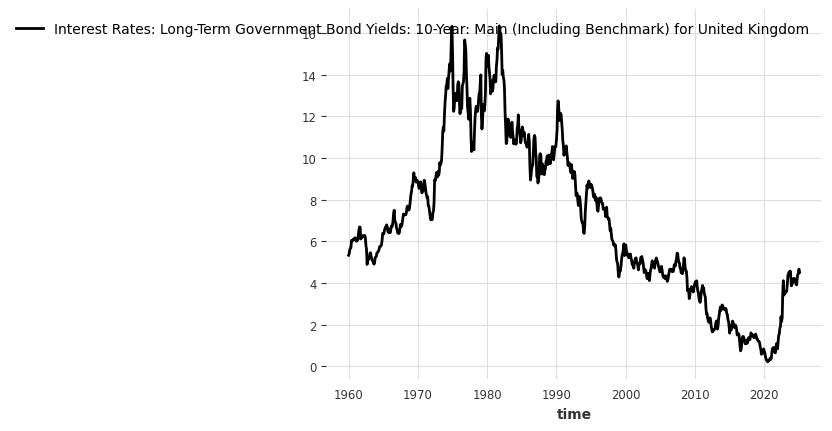

In [21]:
series.plot()
plt.show()

In [22]:
splitting = 0.95
visualizing = 0.9

In [23]:
train, val = series.split_before(splitting)

In [24]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

In [25]:
len(series)

782

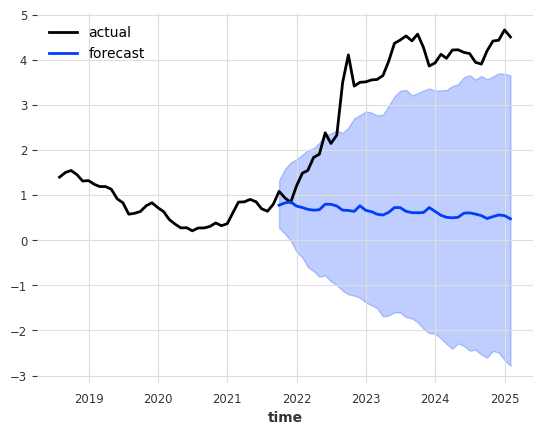

In [26]:
series.drop_before(visualizing).plot(label="actual")  # plot only last 5% of series
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

In [27]:
from darts.models import StatsForecastAutoARIMA

model_aarima = StatsForecastAutoARIMA()
model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(val))

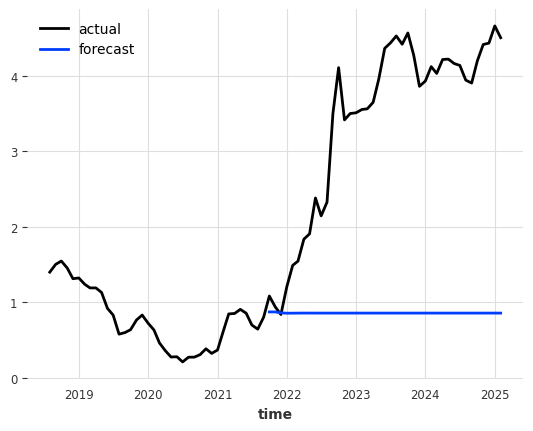

In [28]:
series.drop_before(visualizing).plot(label="actual")  # plot only last 5% of series
prediction_aarima.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

In [29]:
# add part about naive ma model here

In [33]:
from darts.models import NaiveMean, NaiveMovingAverage, Prophet

In [31]:
horizon = 1
points_to_test = 100

In [68]:
def backtest_models(series: TimeSeries, models: list=[StatsForecastAutoETS(), StatsForecastAutoARIMA(), Prophet(suppress_stdout_stderror=True)], horizons: list=[1, 3, 7], points_to_test: int=100, verbose=True):
    backtest_results = dict()
    for horizon in sorted(horizons):
        backtests = [model.historical_forecasts(
            series,
            start=len(series) - points_to_test,
            forecast_horizon=horizon,
            verbose=verbose,
        ) for model in models]
        backtest_results[horizon] = {str(model): (backtests[i], mape(backtests[i], series)) for i, model in enumerate(models)}
    return backtest_results

In [69]:
def plot_backtest_results(series: TimeSeries, backtest_results: dict, points_to_test: int=100):
    for horizon, model in backtest_results.items():
        series.drop_before(len(series) - 2*points_to_test).plot(label='data')
        for model_name, (backtest, mape) in model.items():
            backtest.plot(lw=3, label=f'{model_name}, MAPE={mape:.2f}%')
        plt.title(f'Backtests with {horizon} {series.freq} forecast horizon')
        plt.legend()
        plt.show()

In [70]:
results = backtest_models(series)

historical forecasts:   0%|          | 0/100 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/100 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/100 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/98 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/98 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/98 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/94 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/94 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/94 [00:00<?, ?it/s]

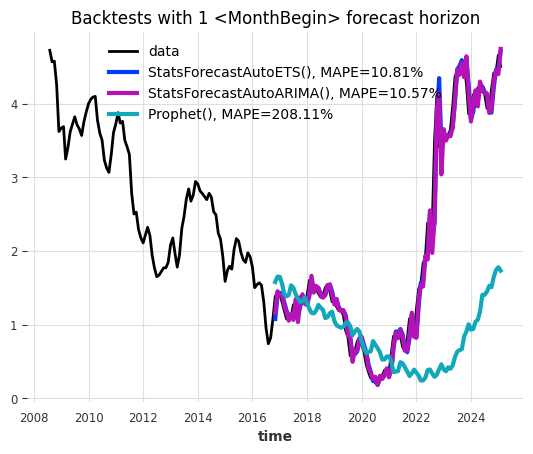

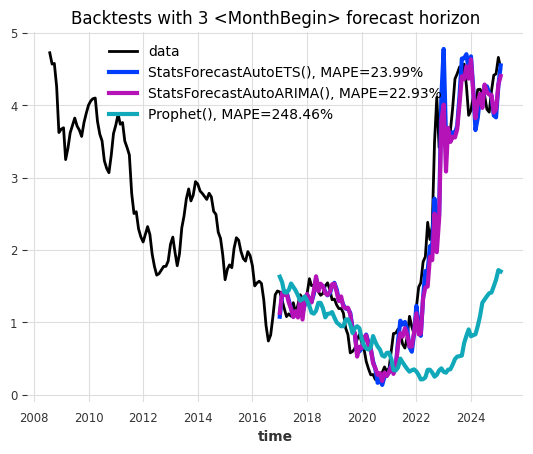

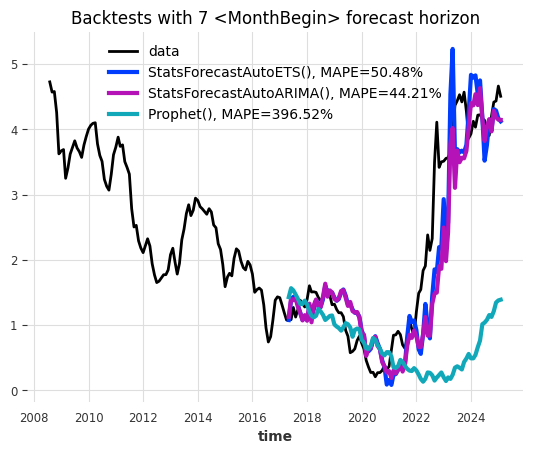

In [71]:
plot_backtest_results(series, results)

In [45]:
horizons = [1, 3, 7, 15, 30]
horizon = [7]

In [61]:
from darts.models import StatsForecastAutoETS

In [62]:
def ETS_optimize(trial: optuna.Trial, series: TimeSeries=series, single_horizon: list=horizon):
    params={
        "season_length": trial.suggest_int("ets_season_length", 1, 365),
        "model": trial.suggest_categorical("ets_e", ["M", "A", "Z"]) + trial.suggest_categorical("ets_t", ["N", "M", "A", "Z"]) + trial.suggest_categorical("ets_s", ["N", "M", "A", "Z"]),
    }
    
    model = StatsForecastAutoETS(**params)
    results = backtest_models(
        series, 
        models=[model], 
        horizons=single_horizon,
        points_to_test=50,
        verbose=False,
    )
    return results[single_horizon[0]][str(model)][1]

In [65]:
model_list = [
    "ETS",
    "StatsForecastAutoARIMA",
    "Prophet",
]
model_family = model_list[0]

In [41]:
def full_optimization(trial: optuna.Trial):
    chosen_model = trial.suggest_categorical

In [66]:
# Create optuna study with defined function and storage
study = optuna.create_study(
    direction="minimize",
    storage=storage,
    study_name=f"{series_name}_{horizon[0]}_{model_family}_study",
    load_if_exists=True
)

[I 2025-04-13 20:14:03,313] A new study created in Journal with name: Interest_Rates_7_ETS_study


In [67]:
# Optimize for n_trials, using all available threads, timeout of 5 min
study.optimize(ETS_optimize, n_trials=1000, n_jobs=-1, timeout=300)

[W 2025-04-13 20:14:49,344] Trial 3 failed with parameters: {'ets_season_length': 276, 'ets_e': 'M', 'ets_t': 'M', 'ets_s': 'A'} because of the following error: ValueError('Forbidden model combination').
Traceback (most recent call last):
  File "C:\Users\avey\miniforge3\envs\astp\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\avey\AppData\Local\Temp\ipykernel_14756\2222252189.py", line 8, in ETS_optimize
    results = backtest_models(
  File "C:\Users\avey\AppData\Local\Temp\ipykernel_14756\394033411.py", line 4, in backtest_models
    backtests = [model.historical_forecasts(
  File "C:\Users\avey\AppData\Local\Temp\ipykernel_14756\394033411.py", line 4, in <listcomp>
    backtests = [model.historical_forecasts(
  File "C:\Users\avey\miniforge3\envs\astp\lib\site-packages\darts\utils\utils.py", line 259, in sanitized_method
    return method_to_sanitize(self, *only_args.values(), **only_kwargs)
  File "C:\Users\

ValueError: Forbidden model combination

In [ ]:
for model in models:
    model.fit(series)
    model.save(f"{model}.pkl")